In [1]:
# pip install -r requirements.txt

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
from tensorflow import data as tf_data


from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D , MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import glob
import xml.etree.cElementTree as et

In [38]:
""" Unzipping data set to a local director  """

from zipfile import ZipFile

with ZipFile("F:\\Coding\\cv_challenge\\archive.zip", 'r') as Dataset:
    Dataset.extractall()

## Task 1 : Convert image data into TFRecordDataset format

In [39]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

### Creating image list and paths

In [40]:
data_folder = ('F:\\Coding\\cv_challenge\\NEU-DET')
train_folder_path = os.path.join(data_folder, "train", )
valid_folder_path = os.path.join(data_folder, "validation", )

def create_img_list(folder_path):
    image_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image_list.append(image_path)

    return image_list

train_img_list = create_img_list(train_folder_path)
valid_img_list = create_img_list(valid_folder_path)


train_anno_path = os.path.join(data_folder,"train", "annotations")
train_anno_files_list = os.listdir(train_anno_path)
valid_anno_path = os.path.join(data_folder,"validation", "annotations")
valid_anno_files_list = os.listdir(valid_anno_path)

### Extracting Lables from XML files

In [41]:
""" Extracting Lables from XML files """

def parseXML(xmlfile):
    # create element tree object 
    tree = et.parse(xmlfile)  
    # get root element 
    root = tree.getroot()

    data = {}
    data['filename'] = root.find('filename').text
    
    source = root.find('source')
    if source is not None:
        data['source_id'] = source.find('database').text
    else:
        data['source_id'] = None

    size = root.find('size')
    data['size'] = {
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }
    
    objects = []
    for obj in root.findall('object'):
        obj_data = {
            'name': obj.find('name').text,
            'pose': obj.find('pose').text,
            'truncated': int(obj.find('truncated').text),
            'difficult': int(obj.find('difficult').text),
            'bndbox': {
                'xmin': int(obj.find('bndbox/xmin').text),
                'ymin': int(obj.find('bndbox/ymin').text),
                'xmax': int(obj.find('bndbox/xmax').text),
                'ymax': int(obj.find('bndbox/ymax').text)
            }
        }
        objects.append(obj_data)

    data['objects'] = objects

    return data

# # Sample data paths
# xml_file_path = 'F:\\Coding\\cv_challenge\\NEU-DET\\train\\annotations\\inclusion_45.xml'
# image_file_path = 'F:\\Coding\cv_challenge\\NEU-DET\\train\\images\\inclusion\\inclusion_45.jpg'

# # Load XML file and parse it
# bounding_boxes_data = parseXML(xml_file_path)

# # Load image
# image = cv2.imread(image_file_path)

# # Draw bounding boxes on the image
# for obj in bounding_boxes_data['objects']:
#     xmin = obj['bndbox']['xmin']
#     ymin = obj['bndbox']['ymin']
#     xmax = obj['bndbox']['xmax']
#     ymax = obj['bndbox']['ymax']
#     cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# # Display the image with bounding boxes
# cv2.imshow('Image with Bounding Boxes', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [42]:
"""
Get distinct class labels from xml files
Returns a list of distinct labels
"""

labels = []
for anno in train_anno_files_list:
    attr = parseXML(train_anno_path +"\\"+anno)
    for obj in attr['objects']:
        label = obj["name"]
        if label not in labels:
            labels.append(label)

print(labels)

"""
Assigning distinct values to each distinct label
"""
image_labels = {name: index for index, name in enumerate(labels)}
n_class = len(image_labels)
print(image_labels)


['crazing', 'patches', 'inclusion', 'pitted_surface', 'rolled-in_scale', 'scratches']
{'crazing': 0, 'patches': 1, 'inclusion': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


In [43]:
def get_image_example(image_string, source_id, width, height, filename, xmin, xmax, ymin, ymax, label, label_text, truncated, difficult):

  feature = {
        "image/width": _int64_feature(width),
        "image/height": _int64_feature(height),
        "image/filename":_bytes_feature(bytes(filename, 'utf-8')),
        'image/source_id': _bytes_feature(bytes(source_id, 'utf-8')),
        "image/encodedrawdata": _bytes_feature(image_string),
        "image/format": _bytes_feature(bytes(filename.split(".")[-1], 'utf-8')),  # Assuming filename contains format
        "image/object/bbox/xmin": _float_feature(xmin),
        "image/object/bbox/xmax": _float_feature(xmax),
        "image/object/bbox/ymin": _float_feature(ymin),
        "image/object/bbox/ymax": _float_feature(ymax),
        "image/object/class/text": _bytes_feature(bytes(label_text, 'utf-8')),
        "image/object/class/label": _int64_feature(label),
        "image/object/class/single": _int64_feature(label),  # Assuming single class per object
        "image/object/difficult": _int64_feature(truncated),
        "image/object/truncated": _int64_feature(difficult),
        "image/object/view": _bytes_feature(bytes("Unspecified", 'utf-8'))  # Assuming view is Unspecified for simplicity
    }

  return tf.train.Example(features=tf.train.Features(feature=feature))

  """
  Followed the article of Reading-Writing TFRecord for Images
  https://www.tensorflow.org/tutorials/load_data/tfrecord
  """

In [44]:
def convert(image_paths,anno_list,anno_path, out_path):

    for img in image_paths:

        img_name_ext = img.split("\\")[-1]
        img_name = img_name_ext.split('.')[0]

        for anno in anno_list:
            anno_name = anno.split(".")[0]
    

            if img_name == anno_name:
                attr = parseXML(anno_path +"\\"+anno)

                image_string = open(img, 'rb').read()

                filename = attr["filename"]
                source_id = attr["source"]["database"] if "source" in attr and "database" in attr["source"] else "Unknown"
                width = attr["size"]["width"]
                height = attr["size"]["height"]

                for obj in attr['objects']:
                    xmin = obj['bndbox']['xmin']
                    ymin = obj['bndbox']['ymin']
                    xmax = obj['bndbox']['xmax']
                    ymax = obj['bndbox']['ymax']
                    label_text = obj["name"]
                    label = image_labels.get(label_text, -1)  # Get label index or -1 if not found
                    truncated = obj["truncated"]
                    difficult = obj["difficult"]


                image_string  = open((img), 'rb').read()
                tf_example = get_image_example(image_string, source_id, width, height, filename, xmin, xmax, ymin, ymax, label, label_text, truncated, difficult)

                file_name_ext = os.path.basename(img)
                file_name = os.path.splitext(file_name_ext)[0]
                output_filename = os.path.join(out_path, f'{file_name}.tfrecord')
                with tf.io.TFRecordWriter(output_filename) as writer:
                    writer.write(tf_example.SerializeToString())

In [45]:
convert(train_img_list,train_anno_files_list ,train_anno_path , 'F:\\Coding\\cv_challenge\\TF_Records\\Train')
convert(valid_img_list,valid_anno_files_list, valid_anno_path ,'F:\\Coding\\cv_challenge\\TF_Records\\Test')

In [46]:
""" Trying to run on one example """

tfr_train = "F:\Coding\cv_challenge\TF_Records\\train\inclusion_45.tfrecord"
raw_image_dataset = tf.data.TFRecordDataset(filenames = [tfr_train])

In [47]:
image_feature_description  = {
      "image/width": tf.io.FixedLenFeature([], tf.int64),
      "image/height": tf.io.FixedLenFeature([], tf.int64),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/source_id': tf.io.FixedLenFeature([], tf.string),
      'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
      'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
      'image/object/difficult': tf.io.VarLenFeature(tf.int64),
      'image/object/truncated': tf.io.VarLenFeature(tf.int64),
      'image/object/view': tf.io.VarLenFeature(tf.string)
  }

def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, image_feature_description )

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

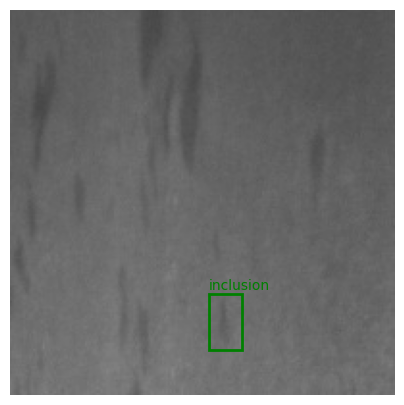

In [48]:
def draw_bounding_boxes(image, bboxes, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    ax = plt.gca()
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 8, label, fontsize=10, color='green', verticalalignment='top')
    plt.axis('off')
    plt.show()

for image_features in parsed_image_dataset:
    image_raw = image_features['image/encodedrawdata'].numpy()
    image = tf.image.decode_jpeg(image_raw)
    filename = image_features['image/filename'].numpy().decode("utf-8")
    bboxes = np.stack([
        image_features["image/object/bbox/xmin"].values.numpy(),
        image_features["image/object/bbox/ymin"].values.numpy(),
        image_features["image/object/bbox/xmax"].values.numpy(),
        image_features["image/object/bbox/ymax"].values.numpy()
    ], axis=-1)
    labels = image_features["image/object/class/text"].values.numpy().astype(str)
    draw_bounding_boxes(image, bboxes, labels)

## Task 2 - Classification

### Building the model

In [27]:
image_height = 200
image_width = 200
n_color_channels = 3
image_size = [image_height,image_width]


base_model = tf.keras.applications.Xception(input_shape=(*[image_height,image_width ],
                                                         n_color_channels),
                                                         include_top=False,
                                                         weights="imagenet")

base_model.trainable = False

inputs = keras.Input(shape=(image_height, image_width, n_color_channels))

x = base_model(inputs, training=False)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(8)(x)
x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
outputs = keras.layers.Dense(6, activation='relu')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)


Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        2086148   N          
                                                       0                    
                                                                            
 batch_normalization_4 (Bat  (None, 7, 7, 2048)        8192      Y          
 chNormalization)                                                           
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                            

### Compiling the Model

In [28]:
"""Converting tfrecords into dataset"""

tfr_train_path = glob.glob("F:\Coding\cv_challenge\TF_Records\Train\*.tfrecord")
tfr_validation_path = glob.glob("F:\Coding\cv_challenge\TF_Records\Test\*.tfrecord")

train_dataset = tf.data.TFRecordDataset(tfr_train_path)
print(train_dataset)
validation_dataset = tf.data.TFRecordDataset(tfr_train_path)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [29]:
"""Decoding the image"""

def decode_image(image, color_channels):
    image = tf.image.decode_jpeg(image, channels = color_channels)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*image_size, 3])
    return image

In [30]:
"""Funtion to read tfrecord files"""

def read_tfrecord(example_proto):

    image_feature_description  = {
      "image/width": tf.io.FixedLenFeature([], tf.int64),
      "image/height": tf.io.FixedLenFeature([], tf.int64),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/source_id': tf.io.FixedLenFeature([], tf.string),
      'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
      'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
      'image/object/difficult': tf.io.VarLenFeature(tf.int64),
      'image/object/truncated': tf.io.VarLenFeature(tf.int64),
      'image/object/view': tf.io.VarLenFeature(tf.string)
    }
    
    example = tf.io.parse_single_example(example_proto, image_feature_description)

    decoded_image = decode_image(example["image/encodedrawdata"], n_color_channels)
    label = tf.cast(tf.sparse.to_dense(example["image/object/class/label"]), tf.int32)  

    return decoded_image, label

In [31]:
mapped_train_dataset = train_dataset.map(read_tfrecord)
mapped_validation_dataset = validation_dataset.map(read_tfrecord)

In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_ds = mapped_train_dataset.batch(BATCH_SIZE).prefetch(tf_data.AUTOTUNE).cache().shuffle(BUFFER_SIZE)
validation_ds = mapped_validation_dataset.batch(BATCH_SIZE).prefetch(tf_data.AUTOTUNE).cache()

In [33]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # metrics=[keras.metrics.Accuracy()],
)

In [34]:
epochs = 30

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 15:
        return 0.001
    elif epoch < 22:
        return 0.0005
    else:
        return 0.0001

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

shift_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [35]:
model_history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[reduce_lr,early_stop, shift_lr])

Epoch 1/30



23/23 [==============================] - 56s 2s/step - loss: 1.9484 - sparse_categorical_accuracy: 0.1432 - val_loss: 1.8296 - val_sparse_categorical_accuracy: 0.3767 - lr: 0.0050
Epoch 2/30
23/23 [==============================] - 52s 2s/step - loss: 1.8124 - sparse_categorical_accuracy: 0.2078 - val_loss: 1.6406 - val_sparse_categorical_accuracy: 0.4371 - lr: 0.0050
Epoch 3/30
23/23 [==============================] - 50s 2s/step - loss: 1.7325 - sparse_categorical_accuracy: 0.2724 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.4239 - lr: 0.0050
Epoch 4/30
23/23 [==============================] - 52s 2s/step - loss: 1.6983 - sparse_categorical_accuracy: 0.2884 - val_loss: 1.3883 - val_sparse_categorical_accuracy: 0.5420 - lr: 0.0050
Epoch 5/30
23/23 [==============================] - 51s 2s/step - loss: 1.6368 - sparse_categorical_accuracy: 0.3197 - val_loss: 1.3245 - val_sparse_categorical_accuracy: 0.5247 - lr: 0.0050
Epoch 6/30
23/23 [==============================] - 51s

### Model Performance

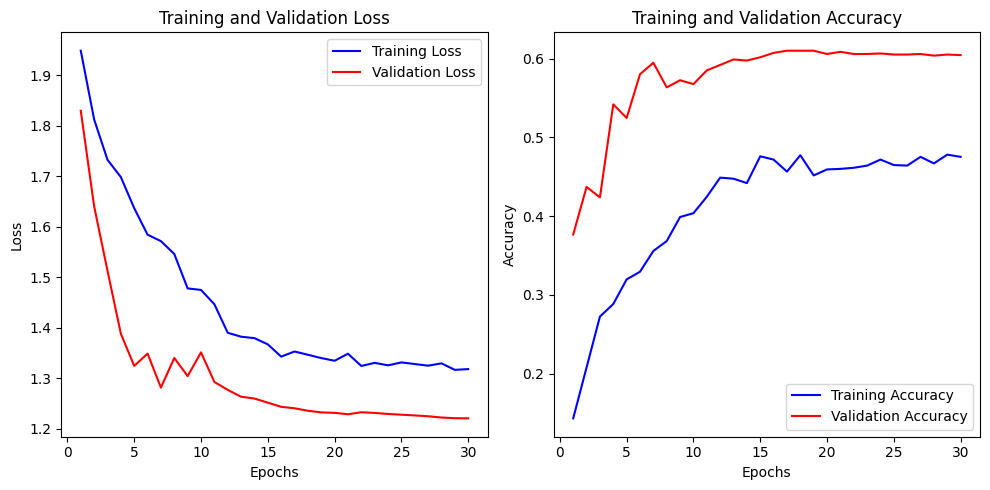

In [36]:
# val_loss, val_accuracy = model.evaluate(validation_ds)
# print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['sparse_categorical_accuracy']
    val_accuracy = model_history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(model_history)